In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report

In [14]:
train_path = 'chest_xray/train'
test_path = 'chest_xray/test'
validation_path = 'chest_xray/val'
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_path)


Found 5216 files belonging to 2 classes.


Text(0.5, 1.0, 'Normal and Pneumonia of Train')

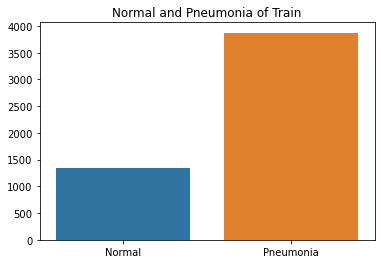

In [16]:
import glob
normal = glob.glob(train_path+"/NORMAL/*.jpeg")
pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

sns.barplot(x=["Normal","Pneumonia"],y=[len(normal),len(pneumonia)])
plt.title('Normal and Pneumonia of Train')

In [3]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0)

valid_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1.0/255.0)

test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
rescale = 1.0 / 255.0)

In [4]:
train_set = train_data_generator.flow_from_directory(
    train_path,
    target_size = (224, 224),
    class_mode = 'binary',
    color_mode = 'grayscale',
    batch_size = 32,
    shuffle = True
)

validation_set = test_data_generator.flow_from_directory(
    validation_path,
    target_size = (224, 224),
    class_mode = 'binary',
    color_mode = 'grayscale',
    batch_size = 32,
    shuffle = True
)


test_set = test_data_generator.flow_from_directory(
    test_path,
    target_size = (224, 224),
    class_mode = 'binary',
    color_mode = 'grayscale',
    batch_size = 32,
    shuffle = False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
model = tf.keras.Sequential([
    layers.Conv2D(32, 3,activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3,activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(1, activation = 'sigmoid')
])

In [6]:
model.compile(
optimizer = 'adam',
loss = 'binary_crossentropy',
metrics = ['accuracy',                     
           tf.keras.metrics.AUC(name = 'AUC'),
           tf.keras.metrics.Precision(name = 'Precision'),
           tf.keras.metrics.Recall(name = 'Recall')])
model_base = model.fit(
    train_set,
    batch_size = 32,
    validation_data = validation_set,
    epochs = 10,)

Epoch 1/10
163/163 [==============================] - 312s 2s/step - loss: 0.2164 - accuracy: 0.9039 - AUC: 0.9603 - Precision: 0.9220 - Recall: 0.9512 - val_loss: 0.6146 - val_accuracy: 0.6875 - val_AUC: 1.0000 - val_Precision: 0.6154 - val_Recall: 1.0000
Epoch 2/10
163/163 [==============================] - 249s 2s/step - loss: 0.0939 - accuracy: 0.9668 - AUC: 0.9923 - Precision: 0.9783 - Recall: 0.9770 - val_loss: 0.5689 - val_accuracy: 0.7500 - val_AUC: 1.0000 - val_Precision: 0.6667 - val_Recall: 1.0000
Epoch 3/10
163/163 [==============================] - 219s 1s/step - loss: 0.0762 - accuracy: 0.9701 - AUC: 0.9948 - Precision: 0.9789 - Recall: 0.9809 - val_loss: 0.0599 - val_accuracy: 1.0000 - val_AUC: 1.0000 - val_Precision: 1.0000 - val_Recall: 1.0000
Epoch 4/10
163/163 [==============================] - 196s 1s/step - loss: 0.0552 - accuracy: 0.9772 - AUC: 0.9969 - Precision: 0.9845 - Recall: 0.9848 - val_loss: 0.3131 - val_accuracy: 0.8125 - val_AUC: 1.0000 - val_Precision: 

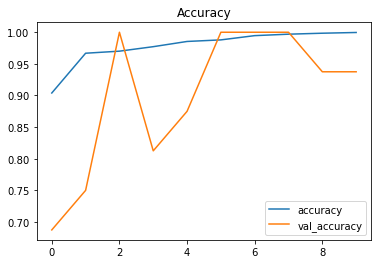

In [8]:
pd.DataFrame(model_base.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

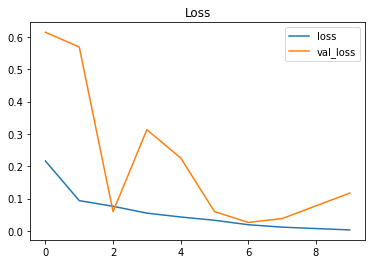

In [9]:
pd.DataFrame(model_base.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
pred = model.predict(test_set)
pred = np.argmax(pred,axis=1)

labels = (test_set.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


print(f' first predictions: {pred[:5]}')

 first predictions: ['NORMAL', 'NORMAL', 'NORMAL', 'NORMAL', 'NORMAL']


In [23]:
results = model_base.model.evaluate(test_set, verbose = 0)
accuracy = results[1]
auc = results[2]
precision = results[3]
recall = results[4]
print("Accuracy:  {:.2f}".format(accuracy))
print("AUC:  {:.2f}".format(auc))
print("Precision:  {:.2f}".format(precision))
print("Recall:  {:.2f}".format(recall))


Accuracy:  0.74
AUC:  0.76
Precision:  0.71
Recall:  0.99


In [24]:
def evaluation(model, test_data):
    
    y_pred = np.squeeze((model_base.model.predict(test_set) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_set.labels, y_pred)
    names = ['TN','Fp','Fn','Tp']
    count = ["{0:0.2f}".format(value) for value in cm.flatten()]
    percentages = ["{0:5%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(names,count,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    

    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=labels, fmt='', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["Negative", "Positive"])
    plt.xlabel("Predict")
    plt.ylabel("true")
    plt.title("Confusion Matrix")
    plt.show()
    
    
    clr = classification_report(test_set.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    print("Classification Report:\n\n", clr)

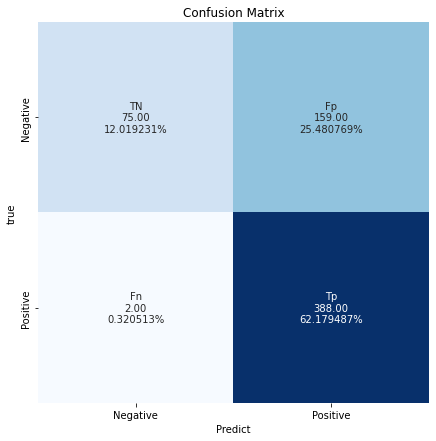

Classification Report:

               precision    recall  f1-score   support

    NEGATIVE       0.97      0.32      0.48       234
    POSITIVE       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



In [25]:
evaluation(model, test_set)